In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import CoraFull, Planetoid, CitationFull
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.nn as gnn 

from src.models import GAT, GraphSAGE, GIN
from src.utils import train_model, test_model
from mean_average_distance import MAD, MADGap
from src.virtualnode import VirtualClassNode, UnidirectionalVirtualClassNode

from tqdm.auto import tqdm
from sklearn.metrics import classification_report

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

SAVE_PATH = 'results'
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/sujin/anaconda3/envs/0606/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

In [3]:
data = dataset[0]
df = pd.DataFrame(data.x)
df['y'] = data.y
train, valid = train_test_split(df, stratify=df.y, test_size=0.4)
valid, test = train_test_split(valid, stratify=valid.y, test_size=0.5)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train.index]=True
data.valid_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.valid_mask[valid.index]=True
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test.index]=True

In [4]:
labels = data.y.numpy()
num_node_ = []
for i in range(70):
    temp = np.where(labels == i)[0]
    num_node_.append(len(temp))

In [5]:
sorted_node = np.argsort(num_node_)[::-1]

In [6]:
mad = MAD(device=device, global_flag=True)
madgap = MADGap(device, 3, 8)

In [7]:
SAVE_PATH = 'model_file'
EARLY_STOPPING = 30

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

In [8]:
optparams = pd.read_csv("./res_stats/training_sage.csv")

In [9]:
optparams.head()

,trial,model,virtualnode,vnode_init,temperature,constrative coef,gaussian_noise_scale,lr,train_acc,train_loss,val_acc,val_loss,test_acc,macro f1,micro f1minor f1,mad,madgap,micro f1,minor f1,positive_sampling
0,64,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,6.569987,0.013822,0.001000,0.003629,0.944914,0.165789,0.716555,0.003321,0.703208,0.644170,NaN,0.863704,0.483508,0.700064,0.487957,True
1,84,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,7.840447,0.021910,0.001000,0.002777,0.939473,0.185297,0.712087,0.004056,0.703208,0.643586,NaN,0.868719,0.491279,0.700527,0.493140,True
2,2,GraphSAGE,VirtualClassNode(),NaN,6.681166,0.058019,0.000001,0.001735,0.994140,0.009016,0.671382,-0.006688,0.663425,0.606996,NaN,0.764222,0.484988,0.659217,0.508190,NaN
3,3,GraphSAGE,VirtualClassNode(),NaN,6.058254,0.340557,0.000010,0.002781,0.991210,-0.021983,0.664185,-0.046624,0.654837,0.596474,NaN,0.825723,0.523051,0.653479,0.454100,NaN
4,4,GraphSAGE,VirtualClassNode(),NaN,2.956950,0.000036,0.000001,0.006563,0.049477,7.893188,0.052867,7.642127,0.051781,0.014052,NaN,0.002419,0.001145,0.027590,0.000000,NaN


In [10]:
optparams.sort_values(by=['macro f1'], ascending=False).head()

,trial,model,virtualnode,vnode_init,temperature,constrative coef,gaussian_noise_scale,lr,train_acc,train_loss,val_acc,val_loss,test_acc,macro f1,micro f1minor f1,mad,madgap,micro f1,minor f1,positive_sampling
0,64,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,6.569987,0.013822,0.001,0.003629,0.944914,0.165789,0.716555,0.003321,0.703208,0.644170,NaN,0.863704,0.483508,0.700064,0.487957,True
1,84,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,7.840447,0.021910,0.001,0.002777,0.939473,0.185297,0.712087,0.004056,0.703208,0.643586,NaN,0.868719,0.491279,0.700527,0.493140,True
5,73,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,6.791155,0.007410,0.001,0.002404,0.902051,0.303335,0.709109,0.029355,0.699924,0.643163,NaN,0.839162,0.489485,0.697414,0.508454,True
9,52,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,7.301587,0.006751,0.001,0.003360,0.937882,0.195050,0.712584,0.007956,0.703208,0.642777,NaN,0.825546,0.472002,0.699861,0.494061,True
10,95,GraphSAGE,UnidirectionalVirtualClassNode(),NaN,7.046566,0.013341,0.001,0.002364,0.926999,0.222144,0.710102,0.013306,0.701440,0.642516,NaN,0.866375,0.495455,0.698893,0.495706,True


In [11]:
for i in [64]:
    g_noise = optparams.loc[i,'gaussian_noise_scale']
    if optparams.loc[i,'model'] == 'Graph Attention Network':
        model = GAT(in_channels=dataset.num_features, hidden_channels=476, number_of_classes=dataset.num_classes, num_of_hidden_layers=4, device=device, heads=1, noise_level=g_noise)
        model_name = 'Graph Attention Network'
    elif optparams.loc[i,'model'] == 'GraphSAGE':
        model = GraphSAGE(in_channels=dataset.num_features, hidden_channels=256, number_of_classes=dataset.num_classes, num_of_hidden_layers=4, device=device, noise_level=g_noise)
        model_name = 'GraphSAGE'
    elif optparams.loc[i,'model'] == 'GIN':
        model = GIN(in_channels=dataset.num_features, hidden_channels=415, number_of_classes=dataset.num_classes, num_of_hidden_layers=4, device=device, noise_level=g_noise)
        model_name = 'GIN'
    vnode = optparams.loc[i,'virtualnode']
    if vnode == "UnidirectionalVirtualClassNode()":
        vc = UnidirectionalVirtualClassNode()
    else:
        vc = VirtualClassNode()

    data.to(device)
    data_for_tuning = vc.forward(data)
    data_for_tuning.to(device)

    model = model.to(device)
    data_for_tuning = data_for_tuning.to(device)

    model.load_state_dict(torch.load(os.path.join(SAVE_PATH, f'SAGE/{model_name}_{i}.pt')))

    
    out, embedding = model(data.x, data.edge_index)
    pred = out.argmax(dim=-1)
    report = classification_report(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), output_dict=True)
    
    result = pd.DataFrame(report).T
    result = model(data_for_tuning.x.to(device), data_for_tuning.edge_index.to(device))[1].cpu()
    global_mad = mad(result).item()
    mad_gap = madgap(result, data_for_tuning.edge_index).item()
    

In [12]:
# test set 
model.eval()
out, embedding = model(data_for_tuning.x, data_for_tuning.edge_index)
vnode_emb = embedding[-70:,:]

testset = embedding[~data_for_tuning.train_mask]
testset_y = data_for_tuning.y[~data_for_tuning.train_mask]

dist = torch.cdist(testset, vnode_emb)
pred_ncm = dist.argmin(dim=-1)

(array([103.,  21.,  97., 151.,  25., 122., 162., 265.,  96., 137.,  56.,
         89.,  41., 208., 136.,  55.,  46.,  44.,  32., 174., 168., 102.,
        166.,  78., 134., 126., 114., 313.,  45., 186.,  88., 150.,  62.,
        342., 231.,  34., 117.,  65.,  50., 226., 112.,  82.,  38.,  21.,
         52., 148.,  49.,  30., 223., 114.,  29., 250., 200., 260.,  40.,
        189., 130., 371.,  85., 120.,  46.,  88.,  66., 116.,  59.,  36.,
         55.,  34.,   6.,  12.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.

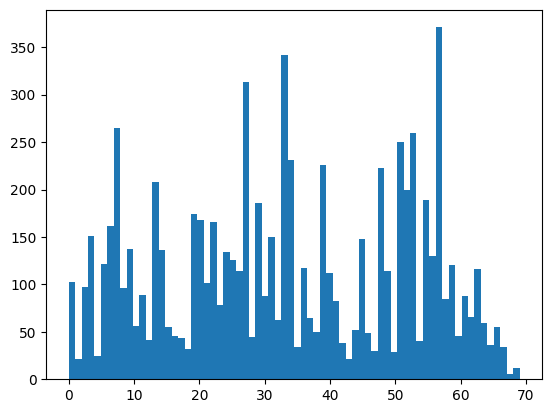

In [13]:
# test data real label
plt.hist(testset_y.cpu().detach().numpy(), bins=70)

(array([ 95.,  21.,  82., 128.,  26., 128., 140., 270., 121., 132.,  53.,
         97.,  25., 193., 151.,  64.,  63.,  53.,  27., 159., 183.,  84.,
        164.,  71., 122., 138.,  72., 358.,  39., 202.,  86., 141.,  53.,
        337., 239.,  42., 153.,  81.,  58., 225., 108.,  83.,  45.,  32.,
         49., 115.,  72.,  25., 228.,  94.,  58., 291., 153., 254.,  46.,
        182., 125., 345.,  68., 139.,  64., 134.,  44., 110.,  63.,  21.,
         40.,  29.,   6.,  19.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.

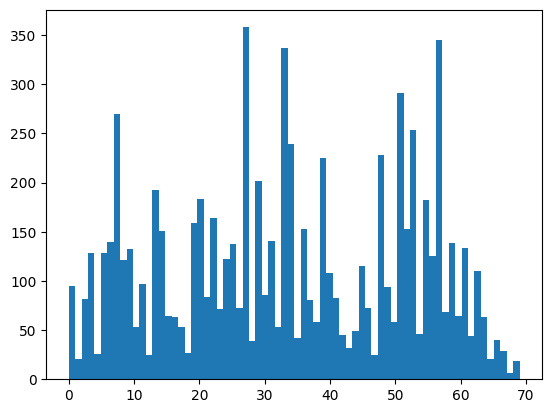

In [14]:
# test data ncm prediction
plt.hist(pred_ncm.cpu().numpy(), bins=70)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.5       , 35.48571429, 36.47142857, 37.45714286, 38.44285714,
        39.42857143, 40.41428571, 41.4       , 42.38571429, 43.37142857,
        44.35714286, 

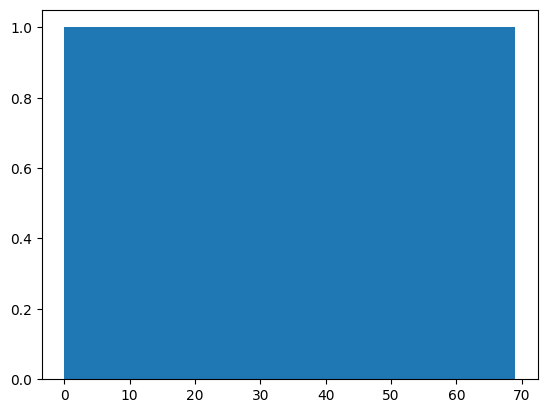

In [15]:
# vnode model prediction
vnode_out = out[-70:,:]
pred = vnode_out.argmax(dim=-1)
plt.hist(pred.cpu().detach().numpy(), bins=70)

(array([110.,   9., 105., 148.,  24., 124., 155., 279., 105., 141.,  49.,
        100.,  26., 206., 156.,  54.,  61.,  45.,  27., 181., 164.,  90.,
        153.,  64., 136., 134.,  77., 333.,  42., 195.,  91., 163.,  58.,
        349., 278.,  30., 141.,  76.,  55., 229., 111.,  79.,  33.,  18.,
         53., 138.,  61.,  26., 217.,  96.,  39., 269., 175., 265.,  22.,
        200., 120., 369.,  85., 128.,  58., 100.,  40.,  98.,  66.,  17.,
         33.,  29.,   1.,   9.]),
 array([ 0.        ,  0.98571429,  1.97142857,  2.95714286,  3.94285714,
         4.92857143,  5.91428571,  6.9       ,  7.88571429,  8.87142857,
         9.85714286, 10.84285714, 11.82857143, 12.81428571, 13.8       ,
        14.78571429, 15.77142857, 16.75714286, 17.74285714, 18.72857143,
        19.71428571, 20.7       , 21.68571429, 22.67142857, 23.65714286,
        24.64285714, 25.62857143, 26.61428571, 27.6       , 28.58571429,
        29.57142857, 30.55714286, 31.54285714, 32.52857143, 33.51428571,
        34.

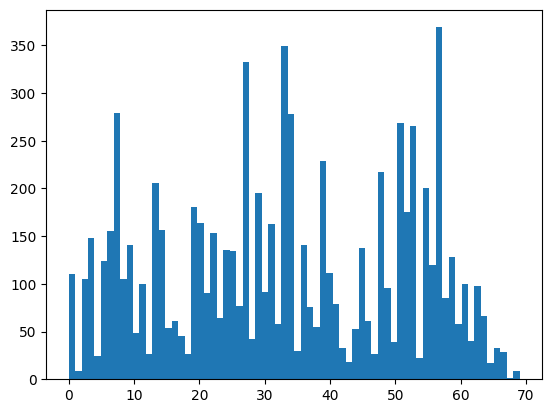

In [16]:
# test data model prediction
pred = out[~data_for_tuning.train_mask].argmax(dim=-1)
plt.hist(pred.cpu().detach().numpy(), bins=70)

In [17]:
import plotly.express as px
from sklearn.manifold import TSNE
TSNE_emb = TSNE(n_components=3).fit_transform(vnode_emb.cpu().detach().numpy())


In [20]:
import plotly.graph_objects as go
import numpy as np


fig = go.Figure(data=[go.Scatter3d(
    x=TSNE_emb[:,0],
    y=TSNE_emb[:,1],
    z=TSNE_emb[:,2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [21]:
from sklearn.manifold import TSNE
TSNE_emb_all = TSNE(n_components=3).fit_transform(embedding.cpu().detach().numpy())

In [65]:
(data.y == 8).nonzero().shape

torch.Size([240, 1])

In [110]:
lst = []
for i in range(70):
    target_classes = sorted_node[i:(i+1)]
    idx_list = []
    for target in target_classes:
        idx = (data.y == target).nonzero().cpu()
        idx_list.extend(idx)
    idx_tensor = torch.cat(idx_list)
    lst.append(idx_tensor)

In [113]:
TSNE_selected = TSNE_emb_all[lst[0],:]

In [114]:
TSNE_selected.shape

(928, 3)

In [115]:
import random

def generate_discrete_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        color = '#' + ''.join(random.choices('0123456789ABCDEF', k=6))
        colors.append(color)
    return colors

# Generating a list of 70 discrete hex colors
discrete_colors70 = generate_discrete_colors(70)


In [116]:
labels = data_for_tuning.y.cpu().tolist()
labels = np.array([discrete_colors70[i] for i in labels])
labels_vnode = np.array([discrete_colors70[i] for i in target_classes])
discrete_colors70=(discrete_colors70)

In [117]:
len(labels)

19863

In [ ]:
lst = []
for i in range(70):
    target_classes = sorted_node[i:(i+1)]
    idx_list = []
    for target in target_classes:
        idx = (data.y == target).nonzero().cpu()
        idx_list.extend(idx)
    idx_tensor = torch.cat(idx_list)
    lst.append(idx_tensor)


In [151]:
jaewoo=24
TSNE_selected = TSNE_emb_all[lst[jaewoo],:]

In [171]:

    TSNE_selected = TSNE_emb_all[lst[i],:]
    fig = go.Figure(data=[go.Scatter3d(
        x=TSNE_emb_all[-70:,0],
        y=TSNE_emb_all[-70:,1],
        z=TSNE_emb_all[-70:,2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.4,
            color = 'blue'
        )
    )])

    # tight layout
    fig.update_layout(margin=dict(l=1, r=1, b=0, t=50), 
                    title=f'Number of nodes: {num_node_[i]}',)

    go.Figure.write_html(fig, file=f'./results/figures/vnodes.html', include_plotlyjs='cdn')
    fig.show()

In [172]:
for i in range(70):
    TSNE_selected = TSNE_emb_all[lst[i],:]
    fig = go.Figure(data=[go.Scatter3d(
        x=TSNE_selected[:,0],
        y=TSNE_selected[:,1],
        z=TSNE_selected[:,2],
        mode='markers',
        marker=dict(
            size=2,
            opacity=0.2,
            color = 'green'
        )
    ), go.Scatter3d(x=TSNE_selected[-70+target_classes,0],
                    y=TSNE_selected[-70+target_classes,1],
                    z=TSNE_selected[-70+target_classes,2],
                    mode='markers',
                    marker=dict(
                        size=20,
                        opacity=0.6,
                        color = 'green'
    ))])

    # tight layout
    fig.update_layout(margin=dict(l=1, r=1, b=0, t=50), 
                    title=f'Number of nodes: {num_node_[i]}',)

    go.Figure.write_html(fig, file=f'./results/figures/class_{i}_{num_node_[i]}.html', include_plotlyjs='cdn')
    # fig.show()

In [97]:
target_classes

array([35, 67, 18, 47, 50,  4, 43,  1, 69, 68])

In [56]:
import random

def generate_discrete_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        color = '#' + ''.join(random.choices('0123456789ABCDEF', k=6))
        colors.append(color)
    return colors

# Generating a list of 70 discrete hex colors
discrete_colors70 = generate_discrete_colors(70)


In [50]:
discrete_colors

['#9615A8',
 '#FAE789',
 '#3A431F',
 '#CB1240',
 '#505636',
 '#A2296A',
 '#793A7A',
 '#E7481F',
 '#F4FB74',
 '#FD1654',
 '#B0D60D',
 '#CFEBDE',
 '#C3C334',
 '#CCA21A',
 '#0C052E',
 '#563CE5',
 '#842EFF',
 '#4DC71C',
 '#3AA6D8',
 '#16415B',
 '#46A5A7',
 '#9F59AA',
 '#7BA100',
 '#F13865',
 '#FB89BE',
 '#AD9F4B',
 '#3735F5',
 '#EA04FF',
 '#D13AF0',
 '#5FC3D8',
 '#9D3CC9',
 '#4FF8C1',
 '#D25C90',
 '#426117',
 '#59739B',
 '#EA4A0F',
 '#D61B7E',
 '#52299B',
 '#69486C',
 '#1AE8D6',
 '#E6D6B5',
 '#54FA71',
 '#16B520',
 '#F8A6DF',
 '#6E0441',
 '#827D58',
 '#14368C',
 '#9A89AB',
 '#04CE52',
 '#2A1BF1',
 '#867245',
 '#F9E2C0',
 '#176963',
 '#851A98',
 '#43F03F',
 '#CC4176',
 '#2838A5',
 '#6B6715',
 '#66A46F',
 '#2F7B56',
 '#1661DB',
 '#3C1A83',
 '#C5FA21',
 '#422C1F',
 '#A799AE',
 '#AF5F57',
 '#7AC951',
 '#7054AF',
 '#1969FB',
 '#0E9398']

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [29]:
# train data real label
train_y = data_for_tuning.y[data_for_tuning.train_mask]
train_emb = embedding[data_for_tuning.train_mask]
vnode_emb = embedding[-70:,:]

train_ncm_label = torch.cdist(train_emb, vnode_emb).argmin(dim=-1)

report = classification_report(train_ncm_label.cpu(), train_y.cpu(), output_dict=True)

In [30]:
pd.set_option('display.max_rows', 1000)

In [31]:
# classification report for train data ncm and real data
result = pd.DataFrame(report).T
result

,precision,recall,f1-score,support
0,0.941935,0.948052,0.944984,154.000000
1,1.000000,0.864865,0.927536,37.000000
2,0.870748,0.977099,0.920863,131.000000
3,0.951754,0.964444,0.958057,225.000000
4,1.000000,0.975000,0.987342,40.000000
5,0.972826,0.957219,0.964960,187.000000
6,0.893004,0.990868,0.939394,219.000000
7,0.899749,0.918159,0.908861,391.000000
8,1.000000,0.941558,0.969900,154.000000
9,0.927184,0.979487,0.952618,195.000000


In [32]:
# train data real label
train_y = data_for_tuning.y[~data_for_tuning.train_mask]
train_emb = embedding[~data_for_tuning.train_mask]
vnode_emb = embedding[-70:,:]

train_ncm_label = torch.cdist(train_emb, vnode_emb).argmin(dim=-1)

report = classification_report(train_ncm_label.cpu(), train_y.cpu(), output_dict=True)
result = pd.DataFrame(report).T
result

,precision,recall,f1-score,support
0,0.708738,0.768421,0.737374,95.000000
1,0.476190,0.476190,0.476190,21.000000
2,0.628866,0.743902,0.681564,82.000000
3,0.662252,0.781250,0.716846,128.000000
4,0.680000,0.653846,0.666667,26.000000
5,0.770492,0.734375,0.752000,128.000000
6,0.802469,0.928571,0.860927,140.000000
7,0.656604,0.644444,0.650467,270.000000
8,0.791667,0.628099,0.700461,121.000000
9,0.788321,0.818182,0.802974,132.000000


In [52]:
train_y = data_for_tuning.y[data_for_tuning.train_mask]
train_emb = embedding[data_for_tuning.train_mask]
vnode_emb = embedding[-70:,:]

res_cv = {}
res_cc = {}
for i in sorted_node:
    class_emb = train_emb[train_y == i]
    v_class = vnode_emb[i].unsqueeze(0)
    res_cv[i] = torch.cdist(class_emb, v_class).mean().item()
    res_cc[i] = torch.cdist(class_emb, class_emb).mean().item()


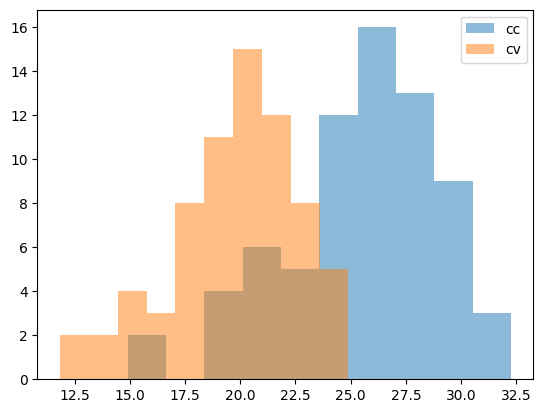

In [53]:
res_cv_lst = res_cv.values()
res_cc_lst = res_cc.values()
plt.hist(res_cc_lst, label='cc', alpha = 0.5)
plt.hist(res_cv_lst, label='cv', alpha = 0.5)
plt.legend()

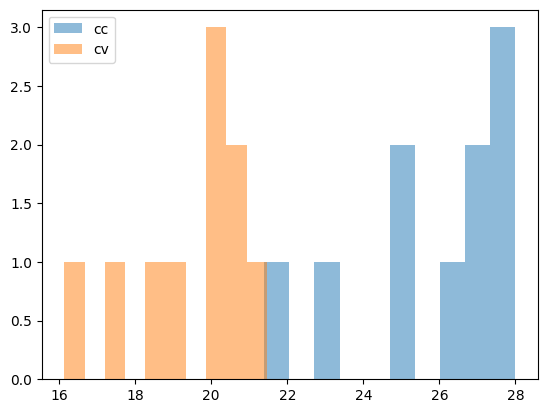

In [56]:
res_cv_lst = res_cv.values()
res_cc_lst = res_cc.values()
plt.hist(list(res_cc_lst)[:10], label='cc', alpha = 0.5)
plt.hist(list(res_cv_lst)[:10], label='cv', alpha = 0.5)
plt.legend()

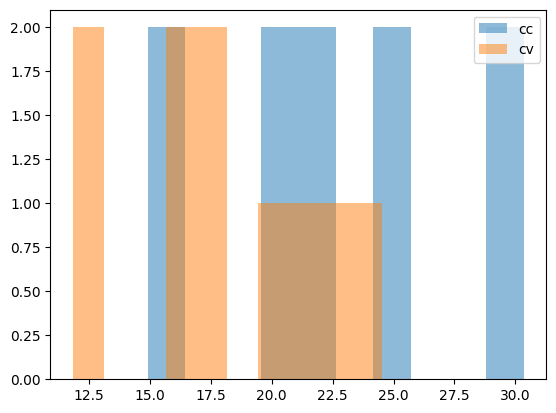

In [57]:
res_cv_lst = res_cv.values()
res_cc_lst = res_cc.values()
plt.hist(list(res_cc_lst)[-10:], label='cc', alpha = 0.5)
plt.hist(list(res_cv_lst)[-10:], label='cv', alpha = 0.5)
plt.legend()